# Imports

In [19]:
from Twitter import TwitterAccess
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
pd.options.display.max_colwidth = None
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import random
import numpy as np
from multiprocessing import  Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin # ???
from sklearn.utils.validation import check_X_y, check_is_fitted # ???
from scipy import sparse #???
from sklearn.linear_model import LogisticRegression


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Add
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

[nltk_data] Downloading package stopwords to /u/arsaikia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Utils

In [20]:
def create_corpus(tweets):
    stop=set(stopwords.words('english'))
    corpus=[]
    for tweet in tqdm(tweets):
#         words=[word.lower() for word in nltk.casual_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        words=[word.lower() for word in nltk.casual_tokenize(tweet)]
        corpus.append(words)
    return corpus


def get_embedding_matrix(word_index, num_words, embedding_dim):
    embedding_dict={}
# with open('./data/glove6B/glove.6B.100d.txt','r') as f:
    with open('../data/gloveTwitter27B/glove.twitter.27B.100d.txt','r') as f:
        for line in f:
            values=line.split()
            word=values[0]
            vectors=np.asarray(values[1:],'float32')
            embedding_dict[word]=vectors
    f.close()
    
    embedding_matrix=np.zeros((num_words,embedding_dim))

    for word,i in tqdm(word_index.items()):
        if i > num_words:
            continue

        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec
    return embedding_matrix

# Architecture

In [21]:
def architecture(text, nclasses, lr):
    corpus=create_corpus(text)
    
    tokenizer_obj = Tokenizer()
    tokenizer_obj.fit_on_texts(corpus) #??
    sequences = tokenizer_obj.texts_to_sequences(corpus) #??

    tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

    word_index = tokenizer_obj.word_index
    print('Number of unique words:',len(word_index))

    num_words = len(word_index)+1
    
    embedding_matrix = get_embedding_matrix(word_index, num_words, embedding_dim)
    
    inputs1 = Input(shape=(MAX_LEN,), name = "trainable")

    embedding = Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                       input_length=MAX_LEN,trainable=True)(inputs1)
    
    convs = []
    for fsz in filter_sizes:
        conv = Conv1D(filters=num_filters,
                             kernel_size=fsz,
                             padding='valid',
                             activation='tanh',
                             use_bias = True)(embedding)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)
    if len(filter_sizes)>1:
        out = Concatenate()(convs)
    else:
        out = convs[0]

    if nclasses >2 :
        outputs = Dense(nclasses, activation='softmax', name = "output")(out)
    else:
        outputs = Dense(1, activation='sigmoid', name = "output")(out)

    model = Model(inputs=inputs1, outputs=outputs)       
    optimizer=Adam(learning_rate=lr)

    if nclasses > 2:
        model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    else:
        model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


    model.summary()
    
    return tweet_pad, model, tokenizer_obj
    

# Train-validate

In [22]:
# train=tweet_pad[:tweet.shape[0]]
# test=tweet_pad[tweet.shape[0]:]

def train_validate(X, y, model, threshold_plot = False, batch_size = 512):
    le = LabelEncoder()
    y = le.fit_transform(y)
    if len(le.classes_) > 2:
        y = np_utils.to_categorical(y)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
    

    # X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
    print('Shape of train',X_train.shape)
    print("Shape of Validation ",X_valid.shape)
    callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )

    history=model.fit(X_train,y_train,
                      batch_size=batch_size,
                      epochs=200,
                      validation_data=(X_valid,y_valid),
                      shuffle = True,
                      verbose=2,
                     callbacks = [callback])

    
    proba_valid = model.predict(X_valid)
    
    proba_train = model.predict(X_train)

    
    if len(le.classes_) > 2:
        preds_valid = (proba_valid == np.max(proba_valid, axis =1).reshape(-1,1)).astype(int)
        preds_train = (proba_train == np.max(proba_train, axis =1).reshape(-1,1)).astype(int)
        
    else:
        preds_valid = np.round(proba_valid)
        preds_train = np.round(proba_train)
        
    print('##### TRAINING DATA #####')
    print(classification_report(y_train, preds_train))
    try:
        print('AUC: ',  roc_auc_score(y_train, proba_train))
    except:
        print('AUC: ',  roc_auc_score(y_train, proba_train, multi_class ='ovr'))
    
    print('##### VALIDATION DATA #####')
    print(classification_report(y_valid, preds_valid))
    try:
        print('AUC: ',  roc_auc_score(y_valid, proba_valid))
    except:
        print('AUC: ',  roc_auc_score(y_valid, proba_valid, multi_class ='ovr'))
        
    if threshold_plot:
        thresholds  = []
        scores = []
        for th in range(1,10):
            thresholds.append(th/10)

            scores.append(f1_score(y_valid, proba_valid > (th/10), average = 'macro'))

        plt.plot(thresholds, scores)
        
    return model

# Test 

In [23]:
def test(X, y, X_test, y_test, tokenizer_obj, model, threshold = 0.5):
    le = LabelEncoder()
    y = le.fit_transform(y)   
    y_test = le.transform(y_test)
    if len(le.classes_) > 2:
        y = np_utils.to_categorical(y)
        y_test = np_utils.to_categorical(y_test)
    
    corpus_test = create_corpus(X_test)
    sequences_test = tokenizer_obj.texts_to_sequences(corpus_test) #??

    X_test = pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

    callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )
    history=model.fit(X,y,
                      batch_size=512,
                      epochs=100,
                      validation_data=(X_test,y_test),
                      shuffle = True,
                      verbose=2,
                     callbacks = [callback])



    print(X_test.shape, y_test.shape)
    proba_test = model.predict(X_test)
    
    if len(le.classes_) > 2:
        preds_test = (proba_test == np.max(proba_test, axis =1).reshape(-1,1)).astype('int')

    else:
        preds_test = (proba_test > threshold).astype('int')
    
    print('##### TEST DATA #####')
    print(classification_report(y_test, preds_test))
    try:
        print('AUC: ',  roc_auc_score(y_test, proba_test))
    except:
        print('AUC: ',  roc_auc_score(y_test, proba_test, multi_class ='ovr'))

# Load Data

In [24]:
PREPROCESSED = '../preprocessed/'

olid = pd.read_csv(PREPROCESSED + 'olid.csv')
olid_traina = olid[~pd.isna(olid['tweet_cleaned'])]
olid_trainb = olid_traina[~pd.isna(olid_traina['subtask_b'])]
olid_trainc = olid_traina[~pd.isna(olid_traina['subtask_c'])]


olid_testa = pd.read_csv(PREPROCESSED + 'olid-levela.csv')
olid_testa = olid_testa[~pd.isna(olid_testa['tweet_cleaned'])]

olid_testb = pd.read_csv(PREPROCESSED + 'olid-levelb.csv')
olid_testb = olid_testb[~pd.isna(olid_testb['tweet_cleaned'])]

olid_testc = pd.read_csv(PREPROCESSED + 'olid-levelc.csv')
olid_testc = olid_testc[~pd.isna(olid_testc['tweet_cleaned'])]

# Subtask A

100%|██████████| 13239/13239 [00:01<00:00, 13020.46it/s]


Number of unique words: 19059


100%|██████████| 19059/19059 [00:00<00:00, 352440.92it/s]


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trainable (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 100)      1906000     trainable[0][0]                  
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 48, 20)       6020        embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 43, 20)       16020       embedding_3[0][0]                
_______________________________________________________________________________________

100%|██████████| 859/859 [00:00<00:00, 9199.96it/s]

##### TRAINING DATA #####
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      5922
           1       0.88      0.75      0.81      2948

    accuracy                           0.88      8870
   macro avg       0.88      0.85      0.86      8870
weighted avg       0.88      0.88      0.88      8870

AUC:  0.9441935001239543
##### VALIDATION DATA #####
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2917
           1       0.69      0.59      0.64      1452

    accuracy                           0.78      4369
   macro avg       0.75      0.73      0.74      4369
weighted avg       0.77      0.78      0.77      4369

AUC:  0.8142068297271339


Epoch 1/100
26/26 - 1s - loss: 0.3717 - accuracy: 0.8475 - val_loss: 0.4235 - val_accuracy: 0.8196
Epoch 2/100
26/26 - 1s - loss: 0.3664 - accuracy: 0.8507 - val_loss: 0.4222 - val_accuracy: 0.8207
Epoch 3/100
26/26 - 1s - loss: 0.3615 - accuracy: 0.8539 - val_loss: 0.4210 - val_accuracy: 0.8207
Epoch 4/100
26/26 - 1s - loss: 0.3569 - accuracy: 0.8554 - val_loss: 0.4198 - val_accuracy: 0.8219
Epoch 5/100
26/26 - 0s - loss: 0.3525 - accuracy: 0.8575 - val_loss: 0.4190 - val_accuracy: 0.8242
Epoch 6/100
26/26 - 1s - loss: 0.3483 - accuracy: 0.8601 - val_loss: 0.4176 - val_accuracy: 0.8254
Epoch 7/100
26/26 - 1s - loss: 0.3442 - accuracy: 0.8631 - val_loss: 0.4167 - val_accuracy: 0.8277
Epoch 8/100
26/26 - 1s - loss: 0.3402 - accuracy: 0.8655 - val_loss: 0.4157 - val_accuracy: 0.8277
Epoch 9/100
26/26 - 1s - loss: 0.3363 - accuracy: 0.8671 - val_loss: 0.4150 - val_accuracy: 0.8289
Epoch 10/100
26/26 - 1s - loss: 0.3325 - accuracy: 0.8686 - val_loss: 0.4141 - val_accuracy: 0.8300
Epoch 11/

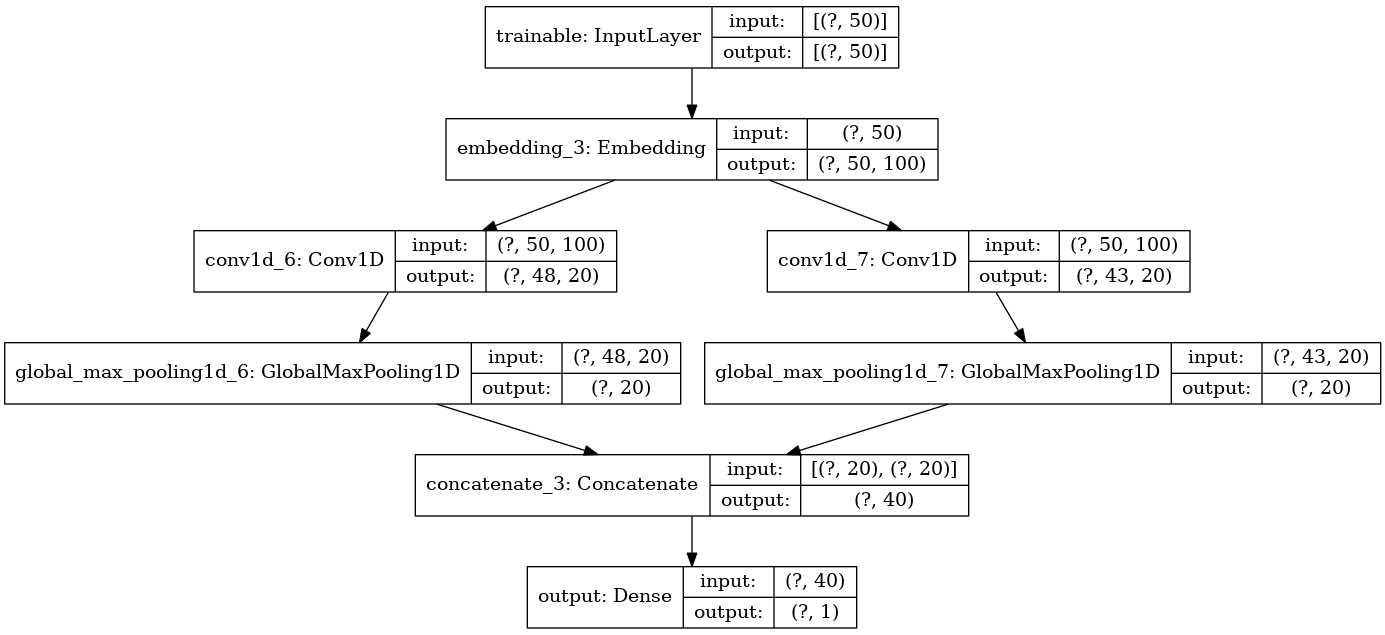

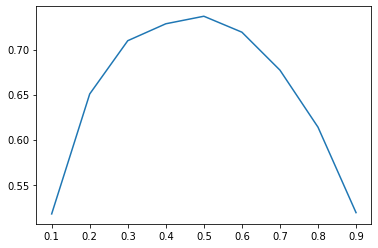

In [16]:
MAX_LEN=50
filter_sizes = (3, 8)
num_filters = 20
embedding_dim = 100
lr = 1e-4

tweet_pada, modela, tokenizer_obj = architecture(olid_traina['tweet_cleaned'], 2,lr)
modela = train_validate(tweet_pada, olid_traina['subtask_a'], modela, True, 512)
test(tweet_pada, olid_traina['subtask_a'], olid_testa['tweet_cleaned'], olid_testa['subtask_a'], tokenizer_obj, modela)


plot_model(modela, show_shapes=True, to_file='cnn1.png')


# Subtask B

100%|██████████| 4400/4400 [00:00<00:00, 11792.07it/s]


Number of unique words: 10272


100%|██████████| 10272/10272 [00:00<00:00, 206038.52it/s]


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trainable (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 100)      1027300     trainable[0][0]                  
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 48, 20)       6020        embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 43, 20)       16020       embedding_5[0][0]                
______________________________________________________________________________________

100%|██████████| 240/240 [00:00<00:00, 9196.02it/s]

##### TRAINING DATA #####
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2599
           1       0.75      0.01      0.02       349

    accuracy                           0.88      2948
   macro avg       0.82      0.50      0.48      2948
weighted avg       0.87      0.88      0.83      2948

AUC:  0.8713087797709279
##### VALIDATION DATA #####
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1277
           1       1.00      0.01      0.01       175

    accuracy                           0.88      1452
   macro avg       0.94      0.50      0.47      1452
weighted avg       0.89      0.88      0.82      1452

AUC:  0.6765902226199799
Epoch 1/100


9/9 - 0s - loss: 0.3139 - accuracy: 0.8816 - val_loss: 0.3126 - val_accuracy: 0.8875
Epoch 2/100
9/9 - 0s - loss: 0.3125 - accuracy: 0.8818 - val_loss: 0.3119 - val_accuracy: 0.8875
Epoch 3/100
9/9 - 0s - loss: 0.3111 - accuracy: 0.8818 - val_loss: 0.3112 - val_accuracy: 0.8875
Epoch 4/100
9/9 - 0s - loss: 0.3097 - accuracy: 0.8818 - val_loss: 0.3105 - val_accuracy: 0.8875
Epoch 5/100
9/9 - 0s - loss: 0.3084 - accuracy: 0.8818 - val_loss: 0.3099 - val_accuracy: 0.8875
Epoch 6/100
9/9 - 0s - loss: 0.3070 - accuracy: 0.8820 - val_loss: 0.3092 - val_accuracy: 0.8875
Epoch 7/100
9/9 - 0s - loss: 0.3057 - accuracy: 0.8820 - val_loss: 0.3086 - val_accuracy: 0.8875
Epoch 8/100
9/9 - 0s - loss: 0.3044 - accuracy: 0.8820 - val_loss: 0.3081 - val_accuracy: 0.8875
Epoch 9/100
9/9 - 0s - loss: 0.3030 - accuracy: 0.8820 - val_loss: 0.3075 - val_accuracy: 0.8875
Epoch 10/100
9/9 - 0s - loss: 0.3017 - accuracy: 0.8823 - val_loss: 0.3069 - val_accuracy: 0.8875
Epoch 11/100
9/9 - 0s - loss: 0.3004 - ac

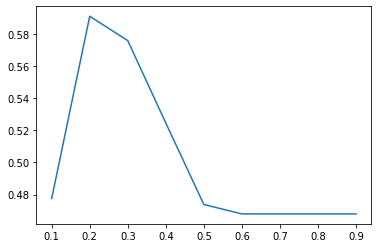

In [25]:
MAX_LEN = 50
filter_sizes = (3, 8)
num_filters = 20
embedding_dim =100
lr = 1e-4

tweet_padb, modelb, tokenizer_obj = architecture(olid_trainb['tweet_cleaned'], 2,lr)
modelb = train_validate(tweet_padb, olid_trainb['subtask_b'], modelb, True, 256)
test(tweet_padb, olid_trainb['subtask_b'], olid_testb['tweet_cleaned'], olid_testb['subtask_b'], tokenizer_obj, modelb, 0.2)


# plot_model(modela, show_shapes=True, to_file='lstm.png')

# Subtask C

In [9]:
MAX_LEN = 50
filter_sizes = (3, 8)
num_filters = 20
embedding_dim = 100

tweet_padc, modelc, tokenizer_obj = architecture(olid_trainc['tweet_cleaned'], 3)
modelc = train_validate(tweet_padc, olid_trainc['subtask_c'], modelc)
test(tweet_padc, olid_trainc['subtask_c'], olid_testc['tweet_cleaned'], olid_testc['subtask_c'], tokenizer_obj, modelc)
# modelc.predict(tweet_padc)

# plot_model(modela, show_shapes=True, to_file='lstm.png')

100%|██████████| 3876/3876 [00:00<00:00, 8261.28it/s]


Number of unique words: 9614


100%|██████████| 9614/9614 [00:00<00:00, 219857.36it/s]


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trainable (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      961500      trainable[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 48, 20)       6020        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 43, 20)       16020       embedding_2[0][0]                
_______________________________________________________________________________________

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 213/213 [00:00<00:00, 8966.06it/s]

##### TRAINING DATA #####
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       735
           1       0.81      0.95      0.88      1600
           2       1.00      0.00      0.01       261

   micro avg       0.79      0.79      0.79      2596
   macro avg       0.85      0.56      0.54      2596
weighted avg       0.81      0.79      0.75      2596
 samples avg       0.79      0.79      0.79      2596

AUC:  0.920747634089229
##### VALIDATION DATA #####
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       339
           1       0.75      0.89      0.81       807
           2       0.00      0.00      0.00       134

   micro avg       0.71      0.71      0.71      1280
   macro avg       0.44      0.48      0.46      1280
weighted avg       0.63      0.71      0.66      1280
 samples avg       0.71      0.71      0.71      1280

AUC:  0.7585633313311403
Epoch 1/100


8/8 - 0s - loss: 0.6202 - accuracy: 0.7626 - val_loss: 0.9382 - val_accuracy: 0.6056
Epoch 2/100
8/8 - 0s - loss: 0.6164 - accuracy: 0.7619 - val_loss: 0.9407 - val_accuracy: 0.6009
Epoch 3/100
8/8 - 0s - loss: 0.6125 - accuracy: 0.7616 - val_loss: 0.9408 - val_accuracy: 0.6009
Epoch 4/100
8/8 - 0s - loss: 0.6086 - accuracy: 0.7634 - val_loss: 0.9386 - val_accuracy: 0.6056
Epoch 5/100
8/8 - 0s - loss: 0.6049 - accuracy: 0.7678 - val_loss: 0.9369 - val_accuracy: 0.6056
Epoch 6/100
8/8 - 0s - loss: 0.6012 - accuracy: 0.7699 - val_loss: 0.9358 - val_accuracy: 0.6103
Epoch 7/100
8/8 - 0s - loss: 0.5977 - accuracy: 0.7719 - val_loss: 0.9375 - val_accuracy: 0.6056
Epoch 8/100
8/8 - 0s - loss: 0.5941 - accuracy: 0.7748 - val_loss: 0.9369 - val_accuracy: 0.6056
Epoch 9/100
8/8 - 0s - loss: 0.5907 - accuracy: 0.7768 - val_loss: 0.9360 - val_accuracy: 0.6056
Epoch 10/100
8/8 - 0s - loss: 0.5873 - accuracy: 0.7797 - val_loss: 0.9336 - val_accuracy: 0.6103
Epoch 11/100
8/8 - 0s - loss: 0.5840 - ac

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
